In [ ]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd

import collections

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/Humana/train_post_oversampling_vacc.csv',index_col = 0)
print('Training data shape: ', train.shape)

Training data shape:  (974842, 268)


In [ ]:
train.dtypes.value_counts()

float64    215
object      50
int64        3
dtype: int64

In [ ]:
new_type = pd.read_csv('/content/gdrive/MyDrive/Humana/updated_type.csv')
cat = new_type["0"][0:67]
num = new_type["1"]

In [ ]:
# Transfer categorical values to object
train[cat] = train[cat].astype('object')
train.dtypes.value_counts()

float64    201
object      67
dtype: int64

In [ ]:
#DO NOT RUN
train["race_cd"].value_counts()

1    813447
2     85731
0     36759
5     14467
3     12230
4     10480
6      1728
Name: race_cd, dtype: int64

In [ ]:
# Figure out variables with high categories
def cat_highlevel(df,threshold):

    column_names = df.columns.values.tolist()
    column_other_encode = []

    for col in df.select_dtypes(include='object'):
        if len(list(df[col].unique())) > threshold:
            column_other_encode.append(col)

    return(column_other_encode)

selected_features = cat_highlevel(train,5)

# Testing
#"rx_maint_pmpm_cost_t_12-9-6m_b4" in selected_features

In [ ]:
# retrieve list of categories for trend variables
cats = list(train["rx_maint_pmpm_cost_t_12-9-6m_b4"].unique())
print(cats)

['Inc_1x-2x', 'No Activity', 'Dec_2x-4x', 'Dec_1x-2x', 'Inc_4x-8x', 'New', 'Dec_4x-8x', 'Inc_2x-4x', 'Dec_over_8x', 'Resolved', 'No_Change', 'Inc_over_8x']


In [ ]:
# Merge Increase and Decrease trend
inc = []
dec = []
for c in cats:
    if "Inc" in c:
        inc.append(c)
    if "Dec" in c:
        dec.append(c)
        
print(inc)
print(dec)

['Inc_1x-2x', 'Inc_4x-8x', 'Inc_2x-4x', 'Inc_over_8x']
['Dec_2x-4x', 'Dec_1x-2x', 'Dec_4x-8x', 'Dec_over_8x']


In [ ]:
# Replace inc, dec with new values

train.replace(inc,"Inc",inplace = True)
train.replace(dec,"Dec",inplace = True)

In [ ]:
# Merge MABH_SEG: MAPD Behavioral Segmentation 

healthy_will = ['H1','H2','H3','H4','H5']
healthy_rel = ['H6','H7','H8']
chronic_will = ['C1','C2','C3','C4','C5']
chronic_rel = ['C6','C7']

train.replace(healthy_will,"H_W",inplace = True)
train.replace(healthy_rel,"H_R",inplace = True)
train.replace(chronic_will,"C_W",inplace = True)
train.replace(chronic_rel,"C_R",inplace = True)

In [ ]:
# Merge CONS_HHCOMP : Indicator of the household composition based on family position and presence of children

train["cons_hhcomp"].replace("U",np.nan,inplace = True)

In [ ]:
train["cons_hhcomp"].unique()

array(['B', 'A', 'L', 'I', 'G', 'D', 'C', 'J', nan, 'K', 'H', 'F', 'E'],
      dtype=object)

In [ ]:
# Merge hum_region: Member geographic information

train.replace("PACIFIC","PR/PACIFIC",inplace = True)
train.replace("PR","PR/PACIFIC",inplace = True)

In [ ]:
# Merge race_cd : Unknown and null

train["race_cd"].replace(0.0,np.nan,inplace = True)

In [ ]:
train[cat] = train[cat].astype('object')
train.dtypes.value_counts()

float64    201
object      67
dtype: int64

In [ ]:
# RUN THIS CELL IF RACE_CD TYPE INCORRECT
train.shape

(974842, 268)

Resampling


In [ ]:
# Divide by class

test_white = test[test["race_cd"] == 1]
test_black = test[test["race_cd"] == 2]
test_other = test[test["race_cd"] == 3]
test_asian = test[test["race_cd"] == 4]
test_hispanic = test[test["race_cd"] == 5]
test_namerica_native = test[test["race_cd"] == 6]
test_unknown = test[test["race_cd"] == np.nan]

Random under-sampling:
1.0    0.616075
2.0    0.264083
5.0    0.044564
3.0    0.037673
4.0    0.032282
6.0    0.005323
Name: race_cd, dtype: float64


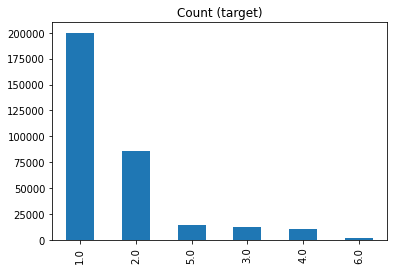

In [ ]:
# Undersampling white

test_other_white = test[test["race_cd"] != 1]

test_white_under = test_white.sample(200000)
df_test_under = pd.concat([test_white_under, test_other_white], axis=0)

print('Random under-sampling:')
print(df_test_under.race_cd.value_counts(normalize=1))

df_test_under.race_cd.value_counts().plot(kind='bar', title='Count (target)')

Random over-sampling:
1.0    0.619395
2.0    0.265509
5.0    0.044814
3.0    0.037882
4.0    0.032400
Name: race_cd, dtype: float64


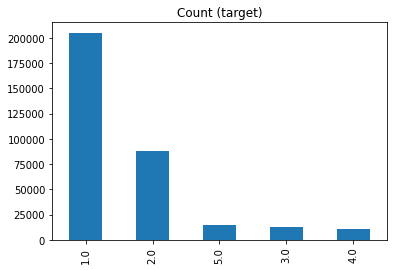

In [ ]:
# Oversampling N Americ Native

test_other_nameric_native = df_test_under[df_test_under["race_cd"] != 6]

test_other_over = test_other_nameric_native.sample(9100, replace=True)
df_test_over = pd.concat([test_other_over, test_other_nameric_native], axis=0)

print('Random over-sampling:')
print(df_test_over.race_cd.value_counts(normalize = 1))

df_test_over.race_cd.value_counts().plot(kind='bar', title='Count (target)');

In [ ]:
df_test_over.race_cd.value_counts()

1.0    205070
2.0     87905
5.0     14837
3.0     12542
4.0     10727
Name: race_cd, dtype: int64

In [ ]:
backup = df_test_over.copy(deep=True)
df_test_over.reset_index(drop=True, inplace=True)
train_updated = pd.DataFrame(data=df_test_over)
train_updated.shape

(368767, 273)

In [ ]:
train_sampling = train_updated

In [ ]:
train_sampling.to_csv('train_post_sampling.csv')

In [ ]:
!cp train_post_sampling.csv "gdrive/My Drive/Colab Notebooks/"

One-Hot Encoding

In [ ]:
### Function: Label Encoding the variables with 2 or fewer unique categories, as one hot encoding preparation
def onehotprep(df):
  # Create a label encoder object
  le = LabelEncoder()
  le_count = 0
  # Iterate through the columns
  for col in df:
      if df[col].dtype == 'object':
        # If 2 or fewer unique categories
          if len(list(df[col].unique())) <= 2:
            # Train on the training data
              le.fit(df[col])
              # Transform both training
              df[col] = le.transform(df[col])
              # Keep track of how many columns were label encoded
              le_count += 1
                
  return print('%d columns were label encoded.' % le_count)

In [ ]:
train_updated = train.copy()

In [ ]:
onehotprep(train_updated)
train_updated['covid_vaccination'].describe()

6 columns were label encoded.


count    974842.000000
mean          0.173826
std           0.378960
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: covid_vaccination, dtype: float64

In [ ]:
train_updated.dtypes.value_counts()

float64    201
object      61
int64        6
dtype: int64

In [ ]:
test = pd.get_dummies(train_updated)
print(test.shape)

test.dtypes.value_counts()
test.head(20)

(974842, 553)


,bh_ncdm_ind,rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4,rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4,total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4,covid_vaccination,sex_cd,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ncal_pmpm_ct,cons_chmi,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,atlas_fsrpth14,atlas_wicspth12,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,cons_cwht,atlas_netmigrationrate1016,atlas_pct_laccess_snap15,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_naturalchangerate1016,ccsp_236_pct,atlas_pct_laccess_hisp15,auth_3mth_dc_no_ref,rx_overall_mbr_resp_pmpm_cost,rx_overall_gpi_pmpm_ct_0to3m_b4,atlas_pct_laccess_hhnv15,credit_bal_consumerfinance,rwjf_uninsured_pct,...,cons_hhcomp_G,cons_hhcomp_H,cons_hhcomp_I,cons_hhcomp_J,cons_hhcomp_K,cons_hhcomp_L,race_cd_1.0,race_cd_2.0,race_cd_3.0,race_cd_4.0,race_cd_5.0,race_cd_6.0,race_age_1,race_age_2,race_age_3,race_age_4,race_age_11,race_age_12,race_age_13,race_age_14,race_age_21,race_age_22,race_age_23,race_age_24,race_age_31,race_age_32,race_age_33,race_age_34,race_age_41,race_age_42,race_age_43,race_age_44,race_age_51,race_age_52,race_age_53,race_age_54,race_age_61,race_age_62,race_age_63,race_age_64
0,0,0,0,0,0,1,-0.064944,1.086122,-0.861781,-2.057716,0.021739,-0.058108,0.038289,-0.068574,-1.311756,-0.213839,-0.145163,-0.158248,0.000577,-0.435859,-0.217516,0.699200,1.091206,-0.207467,0.134057,-0.349892,-0.156668,0.846695,2.115089,-0.591710,-0.174512,0.215786,-0.123161,-0.152441,-0.01592,-0.194952,-0.155394,-0.777575,-0.431114,-0.898407,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,1,-0.064944,-1.202714,0.101038,-0.126105,-0.610068,-0.058108,0.109212,-0.068574,-0.741894,0.303586,-0.145163,-0.167611,-0.329791,-0.435859,-1.180385,0.063614,-0.820376,-0.207467,0.283711,-0.280185,-0.156668,1.174804,2.154126,-0.836778,-0.174512,0.598686,-0.123161,-0.119262,-0.01592,0.013058,0.444256,0.043331,-0.476696,-0.681004,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,-0.064944,0.013994,-1.424635,-1.091910,-0.430022,-0.058108,0.357445,-0.068574,-0.498594,1.779204,-0.128534,-0.097205,1.511167,-0.435859,-0.280310,-0.902755,-0.636227,-0.207467,-0.464558,1.102709,5.544069,-0.137632,1.059536,0.065241,-0.174512,0.703517,-0.123161,0.133092,-0.01592,-0.046800,-0.395254,-0.105456,1.999817,0.009150,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,-0.032595,-0.343739,-0.424366,-0.448040,2.947826,-0.058108,-0.706410,-0.068574,0.968787,1.290092,-0.145163,0.000468,1.263638,-0.435859,-0.121933,-0.023202,-0.829645,-0.207467,-0.614212,2.883595,-0.156668,0.584208,0.199714,1.638835,-0.174512,0.887140,-0.123161,0.222447,-0.01592,-0.331119,-0.395254,-0.538908,-0.107864,1.062569,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,-0.064944,-1.614428,-0.331540,0.784087,-0.636526,-0.058108,1.598610,-0.068574,-2.107904,-1.165291,-0.145163,-0.158977,-1.210703,-0.435859,-0.217516,0.195525,0.044130,-0.207467,1.929903,-1.007120,-0.156668,0.452964,1.381152,-1.485668,-0.174512,-0.086805,-0.123161,0.634454,-0.01592,-0.428564,-0.275324,-1.373634,-1.168768,-0.398194,...,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,1,1,1,0,0,-0.064944,1.042659,0.029529,0.759218,-0.430267,-0.058108,-0.174482,-0.068574,-0.826933,0.432548,-0.145163,-0.079188,0.541042,-0.435859,-0.001526,0.374630,0.007919,0.802644,-0.165250,-0.180222,NaN,-1.581313,1.314520,-0.257874,-0.174512,-0.051496,2.724202,0.791871,-0.01592,-0.383540,-0.155394,-0.419967,-0.620823,-0.522707,...,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,

In [ ]:
train_encoding = test

In [ ]:
#remove columns of high correlation

#correlation criterion
#.00-.19 “very weak”
#.20-.39 “weak”
#.40-.59 “moderate”
#.60-.79 “strong”
#.80-1.0 “very strong”

threshold = 0.9

corr_matrix = train_encoding.corr().abs()

corr_matrix.head()

,bh_ncdm_ind,rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4,rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4,total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4,covid_vaccination,sex_cd,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ncal_pmpm_ct,cons_chmi,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,atlas_fsrpth14,atlas_wicspth12,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,cons_cwht,atlas_netmigrationrate1016,atlas_pct_laccess_snap15,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_naturalchangerate1016,ccsp_236_pct,atlas_pct_laccess_hisp15,auth_3mth_dc_no_ref,rx_overall_mbr_resp_pmpm_cost,rx_overall_gpi_pmpm_ct_0to3m_b4,atlas_pct_laccess_hhnv15,credit_bal_consumerfinance,rwjf_uninsured_pct,...,cons_hhcomp_G,cons_hhcomp_H,cons_hhcomp_I,cons_hhcomp_J,cons_hhcomp_K,cons_hhcomp_L,race_cd_1.0,race_cd_2.0,race_cd_3.0,race_cd_4.0,race_cd_5.0,race_cd_6.0,race_age_1,race_age_2,race_age_3,race_age_4,race_age_11,race_age_12,race_age_13,race_age_14,race_age_21,race_age_22,race_age_23,race_age_24,race_age_31,race_age_32,race_age_33,race_age_34,race_age_41,race_age_42,race_age_43,race_age_44,race_age_51,race_age_52,race_age_53,race_age_54,race_age_61,race_age_62,race_age_63,race_age_64
bh_ncdm_ind,1.000000,0.021981,0.022021,0.024327,0.003727,0.019603,0.004600,0.000933,0.004241,0.007328,0.015048,0.287344,0.018409,0.000470,0.014883,0.039635,0.030831,0.006745,0.038784,0.087918,0.008017,0.012142,0.014956,0.101547,0.009588,0.041545,0.038246,0.003573,0.011611,0.007841,0.002700,0.015529,0.156014,0.011355,0.008038,0.004122,0.071208,0.008035,0.023380,0.020542,...,0.000829,0.004612,0.003414,0.006625,0.000896,0.008093,0.015520,0.023876,0.001631,0.004835,0.002198,0.001605,0.004035,0.010550,0.002170,0.024860,0.011566,0.036272,0.042817,0.083408,0.005503,0.009360,0.015372,0.051602,0.000700,0.004963,0.004243,0.009408,0.001597,0.005419,0.004578,0.003135,0.002716,0.007294,0.001285,0.009492,0.001346,0.001170,0.001923,0.002569
rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4,0.021981,1.000000,0.999361,0.569665,0.042274,0.000187,0.014837,0.004418,0.003703,0.000498,0.010841,0.008016,0.027590,0.000368,0.029546,0.043729,0.035662,0.000778,0.038358,0.013360,0.008930,0.011359,0.005155,0.005654,0.002556,0.031410,0.002372,0.021476,0.011770,0.005741,0.043487,0.005984,0.023784,0.004612,0.000323,0.043249,0.034407,0.003150,0.018525,0.010621,...,0.009399,0.004104,0.010928,0.000156,0.011694,0.003105,0.103244,0.026362,0.004405,0.001980,0.002132,0.004122,0.047596,0.189203,0.057215,0.011029,0.012922,0.173194,0.145153,0.077031,0.009296,0.065745,0.010142,0.012325,0.000655,0.017629,0.010221,0.008680,0.000767,0.024391,0.007135,0.006828,0.000433,0.018258,0.007835,0.006613,0.000836,0.006952,0.001357,0.002502
rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4,0.022021,0.999361,1.000000,0.569869,0.042238,0.000182,0.014870,0.004353,0.003660,0.000496,0.010748,0.008002,0.027611,0.000411,0.029527,0.043614,0.035657,0.000761,0.038334,0.013357,0.008964,0.011310,0.005160,0.005726,0.002536,0.031419,0.002776,0.021547,0.011715,0.005758,0.043468,0.005939,0.023821,0.004569,0.000321,0.043236,0.034436,0.003198,0.018527,0.010624,...,0.009301,0.004017,0.010944,0.000186,0.011671,0.003132,0.103146,0.026281,0.004504,0.001914,0.002010,0.004129,0.047614,0.189272,0.057283,0.011042,0.012941,0.173266,0.145146,0.077015,0.009306,0.065708,0.010228,0.012313,0.000653,0.017551,0.010306,0.008676,0.000769,0.024404,0.007229,0.006823,0.000430,0.018085,0.007872,0.006608,0.000835,0.006958,0.001362,0.002501
total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4,0.024327,0.569665,0.569869,1.000000,0.044787,0.010406,0.012342,0.001129,0.010039,0.002718,0.004417,0.008499,0.023154,0.008678,0.031397,0.039996,0.063138,0.000517,0.040636,0.023913,0.010565,0.0

In [ ]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()

,bh_ncdm_ind,rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4,rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4,total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4,covid_vaccination,sex_cd,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ncal_pmpm_ct,cons_chmi,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,atlas_fsrpth14,atlas_wicspth12,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,cons_cwht,atlas_netmigrationrate1016,atlas_pct_laccess_snap15,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_naturalchangerate1016,ccsp_236_pct,atlas_pct_laccess_hisp15,auth_3mth_dc_no_ref,rx_overall_mbr_resp_pmpm_cost,rx_overall_gpi_pmpm_ct_0to3m_b4,atlas_pct_laccess_hhnv15,credit_bal_consumerfinance,rwjf_uninsured_pct,...,cons_hhcomp_G,cons_hhcomp_H,cons_hhcomp_I,cons_hhcomp_J,cons_hhcomp_K,cons_hhcomp_L,race_cd_1.0,race_cd_2.0,race_cd_3.0,race_cd_4.0,race_cd_5.0,race_cd_6.0,race_age_1,race_age_2,race_age_3,race_age_4,race_age_11,race_age_12,race_age_13,race_age_14,race_age_21,race_age_22,race_age_23,race_age_24,race_age_31,race_age_32,race_age_33,race_age_34,race_age_41,race_age_42,race_age_43,race_age_44,race_age_51,race_age_52,race_age_53,race_age_54,race_age_61,race_age_62,race_age_63,race_age_64
bh_ncdm_ind,NaN,0.021981,0.022021,0.024327,0.003727,0.019603,0.004600,0.000933,0.004241,0.007328,0.015048,0.287344,0.018409,0.000470,0.014883,0.039635,0.030831,0.006745,0.038784,0.087918,0.008017,0.012142,0.014956,0.101547,0.009588,0.041545,0.038246,0.003573,0.011611,0.007841,0.002700,0.015529,0.156014,0.011355,0.008038,0.004122,0.071208,0.008035,0.023380,0.020542,...,0.000829,0.004612,0.003414,0.006625,0.000896,0.008093,0.015520,0.023876,0.001631,0.004835,0.002198,0.001605,0.004035,0.010550,0.002170,0.024860,0.011566,0.036272,0.042817,0.083408,0.005503,0.009360,0.015372,0.051602,0.000700,0.004963,0.004243,0.009408,0.001597,0.005419,0.004578,0.003135,0.002716,0.007294,0.001285,0.009492,0.001346,0.001170,0.001923,0.002569
rej_med_ip_snf_coins_pmpm_cost_t_9-6-3m_b4,NaN,NaN,0.999361,0.569665,0.042274,0.000187,0.014837,0.004418,0.003703,0.000498,0.010841,0.008016,0.027590,0.000368,0.029546,0.043729,0.035662,0.000778,0.038358,0.013360,0.008930,0.011359,0.005155,0.005654,0.002556,0.031410,0.002372,0.021476,0.011770,0.005741,0.043487,0.005984,0.023784,0.004612,0.000323,0.043249,0.034407,0.003150,0.018525,0.010621,...,0.009399,0.004104,0.010928,0.000156,0.011694,0.003105,0.103244,0.026362,0.004405,0.001980,0.002132,0.004122,0.047596,0.189203,0.057215,0.011029,0.012922,0.173194,0.145153,0.077031,0.009296,0.065745,0.010142,0.012325,0.000655,0.017629,0.010221,0.008680,0.000767,0.024391,0.007135,0.006828,0.000433,0.018258,0.007835,0.006613,0.000836,0.006952,0.001357,0.002502
rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4,NaN,NaN,NaN,0.569869,0.042238,0.000182,0.014870,0.004353,0.003660,0.000496,0.010748,0.008002,0.027611,0.000411,0.029527,0.043614,0.035657,0.000761,0.038334,0.013357,0.008964,0.011310,0.005160,0.005726,0.002536,0.031419,0.002776,0.021547,0.011715,0.005758,0.043468,0.005939,0.023821,0.004569,0.000321,0.043236,0.034436,0.003198,0.018527,0.010624,...,0.009301,0.004017,0.010944,0.000186,0.011671,0.003132,0.103146,0.026281,0.004504,0.001914,0.002010,0.004129,0.047614,0.189272,0.057283,0.011042,0.012941,0.173266,0.145146,0.077015,0.009306,0.065708,0.010228,0.012313,0.000653,0.017551,0.010306,0.008676,0.000769,0.024404,0.007229,0.006823,0.000430,0.018085,0.007872,0.006608,0.000835,0.006958,0.001362,0.002501
total_ip_maternity_net_paid_pmpm_cost_t_12-9-6m_b4,NaN,NaN,NaN,NaN,0.044787,0.010406,0.012342,0.001129,0.010039,0.002718,0.004417,0.008499,0.023154,0.008678,0.031397,0.039996,0.063138,0.000517,0.040636,0.023913,0.010565,0.016417,0.006599,0.001853,0.015167,0.024200,0.009449

In [ ]:
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

print('There are %d columns to remove.' % (len(to_drop)))

There are 50 columns to remove.


In [ ]:
train_clean = train_encoding.drop(columns = to_drop)
print('Training shape: ', train_clean.shape)

Training shape:  (974842, 503)


In [ ]:
to_drop

['rej_med_er_net_paid_pmpm_cost_t_9-6-3m_b4',
 'atlas_totalocchu',
 'rx_generic_pmpm_ct_0to3m_b4',
 'rx_gpi2_34_pmpm_ct',
 'atlas_foodinsec_13_15',
 'total_bh_copay_pmpm_cost_t_9-6-3m_b4_No_Change',
 'rx_generic_pmpm_cost_t_6-3-0m_b4_No Activity',
 'atlas_retirement_destination_2015_upda_1.0',
 'rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4_New',
 'rx_overall_dist_gpi6_pmpm_ct_t_6-3-0m_b4_No Activity',
 'atlas_hiamenity_1.0',
 'rx_overall_gpi_pmpm_ct_t_6-3-0m_b4_New',
 'rx_overall_gpi_pmpm_ct_t_6-3-0m_b4_No Activity',
 'rx_overall_gpi_pmpm_ct_t_6-3-0m_b4_Resolved',
 'bh_urgent_care_copay_pmpm_cost_t_12-9-6m_b4_No Activity',
 'bh_urgent_care_copay_pmpm_cost_t_12-9-6m_b4_No_Change',
 'rx_maint_pmpm_cost_t_6-3-0m_b4_No Activity',
 'atlas_hipov_1115_1.0',
 'total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4_No Activity',
 'total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change',
 'total_physician_office_net_paid_pmpm_cost_t_9-6-3m_b4_Resolved',
 'med_outpatient_deduct_pmpm_cost_t_9-

In [ ]:
train_clean.to_csv('train_post_encoding.csv')

In [ ]:
!cp train_post_encoding.csv "/content/gdrive/MyDrive/Colab Notebooks"

Back up for knn(encoding and corr)

In [ ]:
train_clean.to_csv('after_encoding_mean.csv')

In [ ]:
!cp after_encoding_mean.csv "gdrive/My Drive/Humana/after_encoding_mean.csv"

In [ ]:
mean_train_clean = train_encoding.drop(columns = to_drop)

In [ ]:
mean_train_clean.head(20)

,Unnamed: 0,atlas_retirement_destination_2015_upda,atlas_hiamenity,atlas_hipov_1115,atlas_low_employment_2015_update,cms_orig_reas_entitle_cd,atlas_type_2015_update,atlas_farm_to_school13,cons_rxadhm,atlas_persistentchildpoverty_1980_2011,atlas_low_education_2015_update,race_cd,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ncal_pmpm_ct,cons_chmi,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,cons_lwcm10,atlas_fsrpth14,atlas_wicspth12,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,cons_cwht,atlas_netmigrationrate1016,atlas_pct_laccess_snap15,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_naturalchangerate1016,ccsp_236_pct,atlas_pct_laccess_hisp15,rx_overall_mbr_resp_pmpm_cost,rx_overall_gpi_pmpm_ct_0to3m_b4,...,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_New,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No Activity,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No_Change,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_New,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved,cons_hhcomp_A,cons_hhcomp_B,cons_hhcomp_C,cons_hhcomp_D,cons_hhcomp_E,cons_hhcomp_F,cons_hhcomp_G,cons_hhcomp_H,cons_hhcomp_I,cons_hhcomp_J,cons_hhcomp_K,cons_hhcomp_L,cons_hhcomp_U,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4_*,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4_*,auth_3mth_post_acute_trm_*,rx_gpi4_6110_pmpm_ct_*,rx_bh_pmpm_ct_0to3m_b4_6.666666499999999,rx_bh_pmpm_ct_0to3m_b4_*,rx_bh_pmpm_ct_0to3m_b4_6.6666665,auth_3mth_dc_no_ref_*,rx_gpi2_34_dist_gpi6_pmpm_ct_*,lab_albumin_loinc_pmpm_ct_*,rx_gpi2_72_pmpm_ct_6to9m_b4_*,rev_cms_ansth_pmpm_ct_*,rx_gpi2_90_dist_gpi6_pmpm_ct_9to12m_b4_*,rej_total_physician_office_visit_ct_pmpm_0to3m_b4_*,rx_gpi2_56_dist_gpi6_pmpm_ct_3to6m_b4_*,ccsp_065_pmpm_ct_*,rx_gpi2_33_pmpm_ct_0to3m_b4_*
0,0,0.000000,0.000000,0.0,0.000000,0.000000,0.600000,1.000000,0.222222,0.000000,0.000000,0.166667,0.000000,0.253895,0.080931,0.000000,0.468339,0.0,0.262745,0.076902,0.155327,0.000000,0.000632,0.320548,0.303488,0.206949,0.143257,0.000000,0.033333,0.311914,0.000000,0.707071,0.434299,0.050736,0.000000,0.420848,0.000000,0.018989,0.008597,0.048,...,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.222222,0.000000,0.000000,0.166667,0.000000,0.055536,0.156618,0.600000,0.367158,0.0,0.270588,0.131947,0.193346,0.000000,0.000499,0.274017,0.146870,0.165192,0.050666,0.000000,0.040000,0.320818,0.000000,0.757576,0.436958,0.037004,0.000000,0.461106,0.000000,0.019962,0.016252,0.088,...,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2,0.000000,0.000000,0.0,0.000000,0.333333,0.600000,1.000000,0.666667,0.000000,0.000000,0.166667,0.000000,0.160980,0.036685,0.300000,0.395991,0.0,0.298039,0.155448,0.301767,0.000314,0.001499,0.533310,0.293274,0.101703,0.059586,0.000000,0.006667,0.497482,0.159723,0.555556,0.362410,0.087549,0.000000,0.472127,0.000000,0.027363,0.014049,0.032,...,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.000000,0.166667,0.000590,0.129978,0.115316,0.500000,0.936942,0.0,0.180392,0.297187,0.265830,0.000000,0.002887,0.498447,0.319035,0.159488,0.050217,0.000000,0.000000,0.724989,0.000000,0.666667,0.303851,0.175727,0.000000,0.491433,0.000000,0.029984,0.003586,0.032,...,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,4,0.000000,1.000000,0.0,0.000000,0.000000,0.000000,1.000000,0.333333,0.0000

Resampling (back-up for knn
)


In [ ]:
mean_train_clean.to_csv('mean_train_model.csv')

In [ ]:
!cp mean_train_model.csv "gdrive/My Drive/Humana/"

In [ ]:
sampling = pd.read_csv('gdrive/My Drive/Humana/train_sampling.csv')

In [ ]:
sampling.head(10)

,Unnamed: 0,atlas_retirement_destination_2015_upda,atlas_hiamenity,atlas_hipov_1115,cms_orig_reas_entitle_cd,atlas_farm_to_school13,cons_rxadhm,race_cd,auth_3mth_post_acute_dia,rx_gpi2_72_pmpm_cost_6to9m_b4,atlas_pct_laccess_child15,atlas_recfacpth14,atlas_pct_fmrkt_frveg16,atlas_pct_free_lunch14,bh_ip_snf_net_paid_pmpm_cost_9to12m_b4,auth_3mth_acute_ckd,bh_ncal_pmpm_ct,bh_ip_snf_net_paid_pmpm_cost_3to6m_b4,cons_chmi,auth_3mth_post_acute_trm,auth_3mth_post_acute_rsk,rx_gpi4_6110_pmpm_ct,atlas_pc_snapben15,credit_bal_nonmtgcredit_60dpd,rx_bh_mbr_resp_pmpm_cost_9to12m_b4,atlas_pct_laccess_nhna15,credit_hh_nonmtgcredit_60dpd,rx_bh_pmpm_ct_0to3m_b4,cons_lwcm10,atlas_fsrpth14,atlas_wicspth12,cmsd2_sns_digest_abdomen_pmpm_ct,atlas_ghveg_farms12,credit_hh_bankcardcredit_60dpd,total_outpatient_allowed_pmpm_cost_6to9m_b4,cons_cwht,atlas_netmigrationrate1016,atlas_pct_laccess_snap15,rx_nonmaint_mbr_resp_pmpm_cost_9to12m_b4,atlas_naturalchangerate1016,...,hedis_dia_hba1c_ge9_1000,hedis_dia_hba1c_ge9_Y,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Dec,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Inc,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_New,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No Activity,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_No_Change,rx_maint_net_paid_pmpm_cost_t_9-6-3m_b4_Resolved,bh_ip_snf_admit_days_pmpm_t_9-6-3m_b4_1000,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Dec,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Inc,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_New,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No Activity,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_No_Change,rx_phar_cat_cvs_pmpm_ct_t_9-6-3m_b4_Resolved,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_1000,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Dec,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Inc,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_New,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No Activity,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_No_Change,total_physician_office_visit_ct_pmpm_t_6-3-0m_b4_Resolved,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Dec,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Inc,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_New,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_No_Change,rx_generic_dist_gpi6_pmpm_ct_t_9-6-3m_b4_Resolved,cons_hhcomp_A,cons_hhcomp_B,cons_hhcomp_C,cons_hhcomp_D,cons_hhcomp_E,cons_hhcomp_F,cons_hhcomp_G,cons_hhcomp_H,cons_hhcomp_I,cons_hhcomp_J,cons_hhcomp_K,cons_hhcomp_L,cons_hhcomp_U
0,0,0.0,0.000,0.001,0.000,0.001,0.002,0.002,0.0,0.000000,0.047376,0.113019,0.533333,0.616966,0.0,0.0,0.0,0.0,0.172549,0.0,0.0,0.0,0.428376,0.254668,0.0,0.000043,0.373792,0.000000,0.233852,0.093380,0.196454,0.000000,0.000000,0.325259,0.000000,0.747475,0.199057,0.062863,0.000000,0.495928,...,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1,0.0,0.001,0.000,0.000,0.000,0.002,0.000,0.0,0.000000,0.150710,0.217042,0.500000,0.400637,0.0,0.0,0.0,0.0,0.235294,0.0,0.0,0.0,0.250870,0.173236,0.0,0.002162,0.407720,0.000000,0.389728,0.137919,0.073545,0.000000,0.006667,0.344653,0.000000,0.717172,0.384323,0.088997,0.001835,0.441766,...,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,2,0.0,0.000,0.000,0.000,0.001,0.001,0.001,0.0,0.000000,0.152661,0.233175,0.800000,0.414490,0.0,0.0,0.0,0.0,0.184314,0.0,0.0,0.0,0.206982,0.309219,0.0,0.001050,0.471125,0.000000,0.580787,0.191253,0.073815,0.000000,0.000000,0.505654,0.000000,0.333333,0.245015,0.109944,0.000000,0.310413,...,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,3,0.0,0.000,0.001,0.001,0.000,0.002,0.001,0.0,0.001787,0.284054,0.194828,1.000000,NaN,0.0,0.0,0.0,0.0,0.203922,0.0,0.0,0.0,NaN,0.197372,0.0,0.001109,0.433962,0.190476,0.514988,0.103288,0.085453,0.008658,0.126667,0.311559,0.000646,0.383838,0.277771,0.024601,0.000067,0.399023,...,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,4,0.0,0.000,0.000,0.001,0.001,0.001,0.002,0.0,0.000000,0.242812,0.216320,0.245055,0.500241,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,

In [ ]:
#M2:knn

imputer = KNNImputer() # default n_neighbors is 5
knn_train = imputer.fit_transform(sampling)
knn_train_final = pd.DataFrame(knn_train,index=None,columns = num)

NameError: ignored

In [ ]:
knn_train_final.to_csv('knn_train.csv')

NameError: ignored

In [ ]:
!cp knn_train.csv "gdrive/My Drive/Humana/"